In [9]:
import sys
import os
import sacrebleu
import argparse
import numpy as np
from collections import defaultdict
from functools import partial
import pickle
import pdb

from utils import *



def main(args):
    dfs_path = args['input_dir']
    beam_size  = args['beam']
    base_name = os.path.basename(dfs_path)
    dir_name = os.path.dirname(dfs_path)
    cached_path = os.path.join(dir_name, base_name + '.outs')
    print("Computed input directory is {}.".format(dfs_path))
    
    # read in references
    ref_file = args['reference_file']
    refs = read(ref_file)

    if not os.path.exists(cached_path):
        print('Extracting outputs!')
        dfs_outputs = read_split_files(dfs_path, beam_size)

        ### delbpe && detok for texts, evaluate bleu scores
        funct = partial(call_delbpe_and_detok, script_path=args['script_path'])
        dbpe_detok_dfstopk_outputs = process_text_in_moses_format(dfs_outputs, funct)
        with open(cached_path, 'wb') as f:
            pickle.dump(dbpe_detok_dfstopk_outputs, f)
    else:
        print("Reading cached outputs from:")
        print("{}".format(cached_path))
        with open(cached_path, 'rb') as f:
            dbpe_detok_dfstopk_outputs = pickle.load(f)
            
    print('Output dict length: {}'.format(len(dbpe_detok_dfstopk_outputs)))
    dfstopk_scores = score_all_outputs(dbpe_detok_dfstopk_outputs, refs)

#     np.histogram(ed_result_cat, bins=10)
    for i in range(len(dfstopk_scores[0])):
        rank_scores = [item[i] for item in dfstopk_scores]
        if i == 0:
            result_cat = np.array(rank_scores).reshape(1, -1)
        else:
            result_cat = np.concatenate([result_cat, np.array(rank_scores).reshape(1, -1)], axis=0)
    print(result_cat.mean())
    return result_cat
        

root = "/Users/elliott/weixin/beam-search/beam-search-decoding/analysis/scripts"
script_path=os.path.join(root, "../model_errors")
ref_file=os.path.join(root, "../model_errors/test.de.tok.detok")
input_dir = os.path.join(root, "../archive/ende_dfstopk_wmt14.en-de.transformer_new_beam_100")
    
args = {
    'input_dir': input_dir,
    'beam': 5,
    'reference_file': ref_file,
    'script_path': script_path
}
result_cat = main(args)
# def parse_args(args=None):
#     parser = argparse.ArgumentParser(
#         usage="compute_model_errors.py [<args>] [-h | --help]"
#     )

#     # in moses format
#     parser.add_argument("--input_dir", type=str, default="")
#     parser.add_argument("--beam", type=int, default=5)
#     parser.add_argument("--reference_file", type=str, default="")
#     parser.add_argument("--script_path", type=str, default="")
#     parser.add_argument("--disable_cache", action='store_true')

#     return parser.parse_args(args)

# if __name__ == '__main__':
#     args = parse_args()
#     main(args)

Computed input directory is /Users/elliott/weixin/beam-search/beam-search-decoding/analysis/scripts/../archive/ende_dfstopk_wmt14.en-de.transformer_new_beam_100.
Reading cached outputs from:
/Users/elliott/weixin/beam-search/beam-search-decoding/analysis/scripts/../archive/ende_dfstopk_wmt14.en-de.transformer_new_beam_100.outs


  0%|          | 3/3003 [00:00<01:48, 27.54it/s]

Output dict length: 3003


100%|██████████| 3003/3003 [01:20<00:00, 37.14it/s]


14.141080447903068


[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.43316236e-03
 2.42832165e+01 5.21093455e-02]


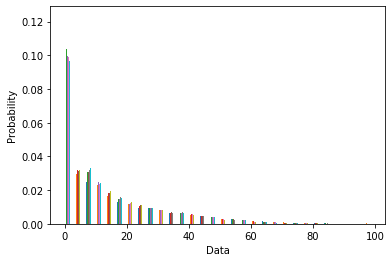

In [24]:
def paint_histogram(result_cat):
    hists = []
    for i in range(0, 20):
#         hists.append(np.histogram(result_cat[i*5:(i+1)*5], bins=10))
        hists.append(result_cat[i*10:(i+1)*10].reshape(-1))
    return hists

hists = paint_histogram(result_cat)
print(hists[0])

import matplotlib.pyplot as plt

fig = plt.figure()
plt.hist(hists, density=True, bins=30)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data')
plt.savefig(root + '/../hist.png')
# plt.close(fig)
